# MNIST Digit Classification with Keras

## What are we building?
A neural network that looks at images of handwritten digits (0-9) and predicts which digit it is.

## What is MNIST?
MNIST is a dataset of **70,000 grayscale images** of handwritten digits, each **28x28 pixels**:
- **60,000** training images
- **10,000** test images

It's the "Hello World" of machine learning — simple enough to learn from, complex enough to be meaningful.

## What will we do?
We'll run **4 experiments** with increasingly complex architectures and compare their performance using confusion matrices and accuracy metrics.

## 1. Setup & Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import os

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Create results directory if needed
os.makedirs('results', exist_ok=True)

print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

2026-02-08 04:52:51.159665: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-08 04:52:51.159834: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-08 04:52:51.184930: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
Keras version: 3.13.2


2026-02-08 04:52:51.934960: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-08 04:52:51.935127: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## 2. Data Loading & Exploration

MNIST comes built into Keras. `load_data()` returns two tuples:
- `(X_train, y_train)` — 60,000 images and their labels
- `(X_test, y_test)` — 10,000 images and their labels

Each image is a 28x28 NumPy array with pixel values 0-255 (grayscale).
Each label is an integer 0-9.

In [2]:
# Load the MNIST dataset
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()

print(f'Training images shape: {X_train_raw.shape}')   # (60000, 28, 28)
print(f'Training labels shape: {y_train_raw.shape}')   # (60000,)
print(f'Test images shape:     {X_test_raw.shape}')     # (10000, 28, 28)
print(f'Test labels shape:     {y_test_raw.shape}')     # (10000,)
print(f'Pixel value range:     {X_train_raw.min()} to {X_train_raw.max()}')
print(f'Label values:          {np.unique(y_train_raw)}')

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape:     (10000, 28, 28)
Test labels shape:     (10000,)
Pixel value range:     0 to 255
Label values:          [0 1 2 3 4 5 6 7 8 9]


### Sample Digits
Let's look at what the data actually contains — a grid of example digits.

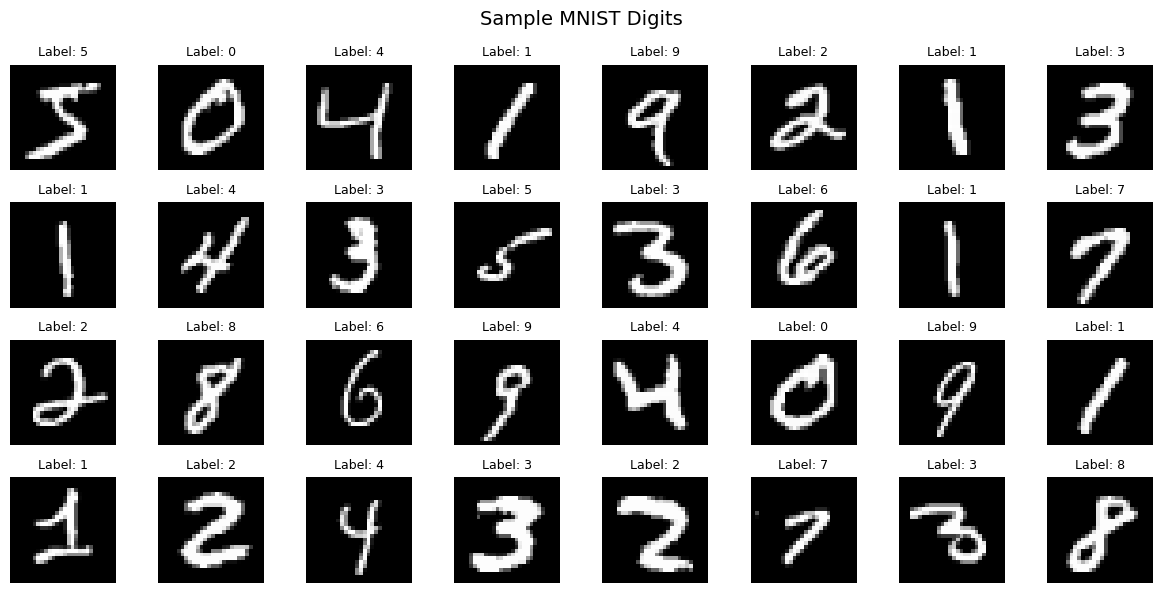

In [3]:
# Display a 4x8 grid of sample digits
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_raw[i], cmap='gray')
    ax.set_title(f'Label: {y_train_raw[i]}', fontsize=9)
    ax.axis('off')
plt.suptitle('Sample MNIST Digits', fontsize=14)
plt.tight_layout()
plt.savefig('results/sample_digits.png', dpi=150, bbox_inches='tight')
plt.show()

### Class Distribution
Are the digits evenly distributed, or are some more common? An imbalanced dataset could bias the model.

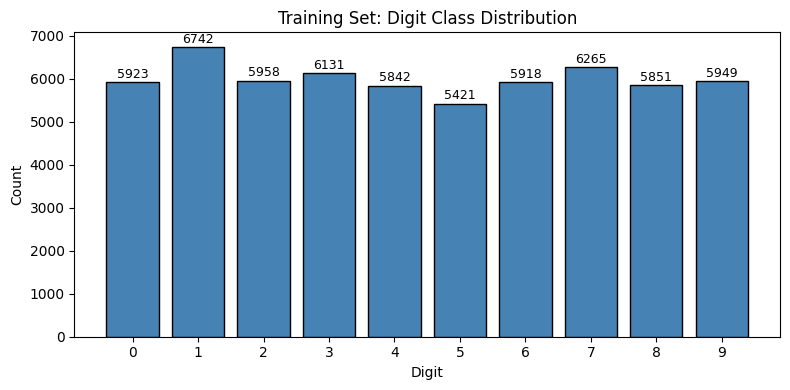

In [4]:
# Count how many of each digit we have
unique, counts = np.unique(y_train_raw, return_counts=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(unique, counts, color='steelblue', edgecolor='black')
ax.set_xlabel('Digit')
ax.set_ylabel('Count')
ax.set_title('Training Set: Digit Class Distribution')
ax.set_xticks(range(10))
for i, (val, cnt) in enumerate(zip(unique, counts)):
    ax.text(val, cnt + 100, str(cnt), ha='center', fontsize=9)
plt.tight_layout()
plt.savefig('results/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Data Preprocessing

We need three transformations before feeding data to a neural network:

### 3.1 Normalization
Pixel values are 0-255. We divide by 255.0 to scale them to **[0, 1]**.
- Neural networks train faster with small input values
- Prevents large pixel values from dominating gradient updates

### 3.2 Flattening
Images are 28x28 (2D). Dense layers expect a 1D vector, so we reshape each image to **784** values.
- `28 * 28 = 784`
- This loses spatial information (a CNN would preserve it, but Dense layers don't use it)

### 3.3 One-Hot Encoding
Labels are integers (e.g., `5`). We convert them to binary vectors:
- `5` becomes `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]`
- This is required because our output layer uses **softmax**, which outputs probabilities for each class
- The loss function (categorical crossentropy) compares these probability vectors

In [5]:
# --- Normalization: scale pixels from [0, 255] to [0, 1] ---
X_train_norm = X_train_raw.astype('float32') / 255.0
X_test_norm = X_test_raw.astype('float32') / 255.0

# --- Flattening: reshape from (N, 28, 28) to (N, 784) ---
X_train = X_train_norm.reshape(-1, 784)
X_test = X_test_norm.reshape(-1, 784)

# --- One-hot encoding: integer labels to binary vectors ---
y_train = to_categorical(y_train_raw, num_classes=10)
y_test = to_categorical(y_test_raw, num_classes=10)

# Verify the transformations
print('After preprocessing:')
print(f'  X_train shape: {X_train.shape}')        # (60000, 784)
print(f'  X_test shape:  {X_test.shape}')          # (10000, 784)
print(f'  y_train shape: {y_train.shape}')         # (60000, 10)
print(f'  y_test shape:  {y_test.shape}')           # (10000, 10)
print(f'  Pixel range:   {X_train.min():.1f} to {X_train.max():.1f}')
print(f'  Example label: {y_train_raw[0]} -> {y_train[0]}')

After preprocessing:
  X_train shape: (60000, 784)
  X_test shape:  (10000, 784)
  y_train shape: (60000, 10)
  y_test shape:  (10000, 10)
  Pixel range:   0.0 to 1.0
  Example label: 5 -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 4. Helper Functions

We define reusable functions for training curves, confusion matrices, and evaluation.
This avoids repeating the same code in each experiment.

In [6]:
def plot_training_curves(history, exp_name):
    """Plot and save accuracy and loss curves for training and validation."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title(f'{exp_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title(f'{exp_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    filename = f'results/training_curves_{exp_name}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filename}')

In [7]:
def plot_confusion_matrix(y_true, y_pred, exp_name):
    """Plot and save a confusion matrix heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=range(10), yticklabels=range(10), ax=ax
    )
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{exp_name} - Confusion Matrix')
    plt.tight_layout()
    filename = f'results/confusion_matrix_{exp_name}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filename}')
    return cm

In [8]:
def evaluate_model(model, X_test, y_test, y_test_labels, exp_name):
    """Run full evaluation: accuracy, confusion matrix, classification report."""
    # Test accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'\n{exp_name} Results:')
    print(f'  Test Loss:     {loss:.4f}')
    print(f'  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')

    # Predictions
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion matrix
    cm = plot_confusion_matrix(y_test_labels, y_pred, exp_name)

    # Classification report
    report = classification_report(y_test_labels, y_pred)
    print(f'\nClassification Report:\n{report}')

    # Save report to file
    report_path = f'results/classification_report_{exp_name}.txt'
    with open(report_path, 'w') as f:
        f.write(f'{exp_name} - Classification Report\n')
        f.write(f'Test Accuracy: {accuracy:.4f}\n\n')
        f.write(report)
    print(f'Saved: {report_path}')

    return accuracy, y_pred, cm

## 5. Model Builder Functions

Each function builds one of our 4 experiment architectures.
Defining them as functions lets us test them before training.

In [9]:
def build_model_exp1():
    """Experiment 1: Simple baseline - single hidden layer."""
    model = keras.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model


def build_model_exp2():
    """Experiment 2: Deeper network - two hidden layers."""
    model = keras.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model


def build_model_exp3():
    """Experiment 3: Deeper + dropout regularization."""
    model = keras.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])
    return model


def build_model_exp4():
    """Experiment 4: Wider and deeper tuned network."""
    model = keras.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

---

## 6. Experiment 1: Simple Baseline

**Architecture:** `Input(784) → Dense(128, ReLU) → Dense(10, Softmax)`

This is the simplest possible network for this task:
- One hidden layer with 128 neurons and ReLU activation
- Output layer with 10 neurons (one per digit) and softmax activation
- **Total parameters:** ~100K

This establishes our baseline to compare against.

In [10]:
tf.random.set_seed(42)
model_exp1 = build_model_exp1()

# compile() configures the model for training:
#   optimizer='adam' - adaptive learning rate, fast convergence
#   loss='categorical_crossentropy' - standard for multi-class with one-hot labels
#   metrics=['accuracy'] - track accuracy during training
model_exp1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_exp1.summary()

E0000 00:00:1770519173.831401 1041326 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1770519173.838028 1041326 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# fit() trains the model:
#   batch_size=128 - process 128 images before updating weights
#   epochs=10 - pass through entire training set 10 times
#   validation_split=0.1 - use 10% of training data for validation monitoring
history_exp1 = model_exp1.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 2:38 376ms/step - accuracy: 0.0781 - loss: 2.3995

 33/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4965 - loss: 1.7135    

 68/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6208 - loss: 1.3553

111/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6905 - loss: 1.1229

154/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7297 - loss: 0.9851

187/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7506 - loss: 0.9107

222/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7677 - loss: 0.8492

257/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7814 - loss: 0.7999

291/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7924 - loss: 0.7598

328/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8026 - loss: 0.7229

371/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.6866

410/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8201 - loss: 0.6586

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8961 - loss: 0.3794 - val_accuracy: 0.9542 - val_loss: 0.1729


Epoch 2/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9453 - loss: 0.1871

 41/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9397 - loss: 0.2012 

 78/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9410 - loss: 0.2008

121/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9415 - loss: 0.1999

156/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9417 - loss: 0.1997

193/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9419 - loss: 0.1996

231/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9421 - loss: 0.1990

271/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9425 - loss: 0.1980

307/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9429 - loss: 0.1967

348/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9435 - loss: 0.1951

384/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9439 - loss: 0.1937

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9443 - loss: 0.1926

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9493 - loss: 0.1771 - val_accuracy: 0.9640 - val_loss: 0.1289


Epoch 3/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9609 - loss: 0.1275

 34/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9606 - loss: 0.1351 

 66/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9606 - loss: 0.1368

101/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9605 - loss: 0.1374

135/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9604 - loss: 0.1378

168/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9602 - loss: 0.1383

205/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9600 - loss: 0.1389

237/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9600 - loss: 0.1389

276/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9601 - loss: 0.1386

311/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9603 - loss: 0.1381

345/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9605 - loss: 0.1375

383/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9607 - loss: 0.1367

417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9609 - loss: 0.1362

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9628 - loss: 0.1289 - val_accuracy: 0.9672 - val_loss: 0.1100


Epoch 4/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9766 - loss: 0.1128

 34/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9710 - loss: 0.1043 

 68/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9705 - loss: 0.1055

103/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9699 - loss: 0.1060

138/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9696 - loss: 0.1064

173/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9693 - loss: 0.1068

210/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9692 - loss: 0.1072

247/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9692 - loss: 0.1072

279/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9693 - loss: 0.1070

316/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9694 - loss: 0.1066

354/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9695 - loss: 0.1061

388/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9697 - loss: 0.1057

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9712 - loss: 0.1004 - val_accuracy: 0.9693 - val_loss: 0.1000


Epoch 5/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9844 - loss: 0.0992

 34/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9764 - loss: 0.0838 

 57/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9762 - loss: 0.0843

 91/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9757 - loss: 0.0851

128/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9754 - loss: 0.0853

168/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9751 - loss: 0.0857

201/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 0.0859

237/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 0.0860

274/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9750 - loss: 0.0859

308/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9751 - loss: 0.0856

343/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9752 - loss: 0.0852

380/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9754 - loss: 0.0848

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9755 - loss: 0.0846

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9768 - loss: 0.0809 - val_accuracy: 0.9732 - val_loss: 0.0931


Epoch 6/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9844 - loss: 0.0853

 36/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9817 - loss: 0.0677 

 71/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9814 - loss: 0.0687

111/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9808 - loss: 0.0692

134/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9806 - loss: 0.0694

167/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9804 - loss: 0.0697

201/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9803 - loss: 0.0700

235/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9803 - loss: 0.0701

271/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9803 - loss: 0.0701

306/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9804 - loss: 0.0699

342/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9804 - loss: 0.0696

394/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9805 - loss: 0.0693

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9812 - loss: 0.0667 - val_accuracy: 0.9737 - val_loss: 0.0894


Epoch 7/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9844 - loss: 0.0716

 36/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9859 - loss: 0.0559 

 71/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9848 - loss: 0.0568

106/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9840 - loss: 0.0573

140/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9836 - loss: 0.0576

174/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9835 - loss: 0.0579

211/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9834 - loss: 0.0581

246/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9835 - loss: 0.0581

280/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9836 - loss: 0.0581

315/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9837 - loss: 0.0580

348/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9838 - loss: 0.0578

386/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9839 - loss: 0.0575

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9847 - loss: 0.0555 - val_accuracy: 0.9743 - val_loss: 0.0854


Epoch 8/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9844 - loss: 0.0582

 44/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9872 - loss: 0.0465 

 80/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9868 - loss: 0.0473

110/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9864 - loss: 0.0477

149/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9861 - loss: 0.0481

182/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9860 - loss: 0.0483

227/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9861 - loss: 0.0485

256/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9861 - loss: 0.0485

287/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9863 - loss: 0.0485

319/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9864 - loss: 0.0484

353/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9865 - loss: 0.0483

392/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9866 - loss: 0.0481

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9874 - loss: 0.0466 - val_accuracy: 0.9753 - val_loss: 0.0827


Epoch 9/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9844 - loss: 0.0457

 33/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0379 

 67/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 0.0389

 98/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9887 - loss: 0.0396

130/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0400

164/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0403

201/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0404

239/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0405

269/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9887 - loss: 0.0406

302/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0405

337/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 0.0404

375/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0403

418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9891 - loss: 0.0402

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9898 - loss: 0.0393 - val_accuracy: 0.9762 - val_loss: 0.0809


Epoch 10/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9844 - loss: 0.0363

 33/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0310 

 69/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9915 - loss: 0.0321

106/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9913 - loss: 0.0328

139/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9912 - loss: 0.0332

177/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9911 - loss: 0.0335

213/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9912 - loss: 0.0336

244/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9912 - loss: 0.0337

281/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9912 - loss: 0.0337

317/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9913 - loss: 0.0337

352/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9914 - loss: 0.0336

390/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9914 - loss: 0.0336

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9920 - loss: 0.0330 - val_accuracy: 0.9778 - val_loss: 0.0796


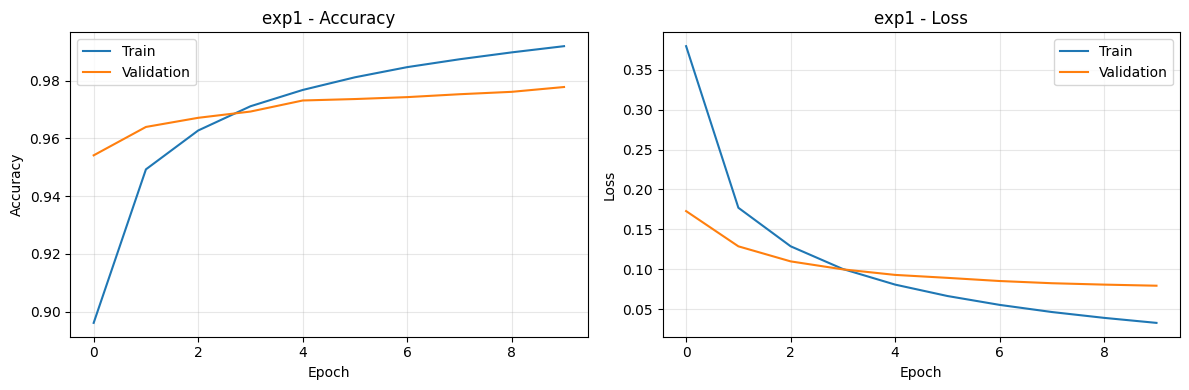

Saved: results/training_curves_exp1.png



exp1 Results:
  Test Loss:     0.0839
  Test Accuracy: 0.9731 (97.31%)


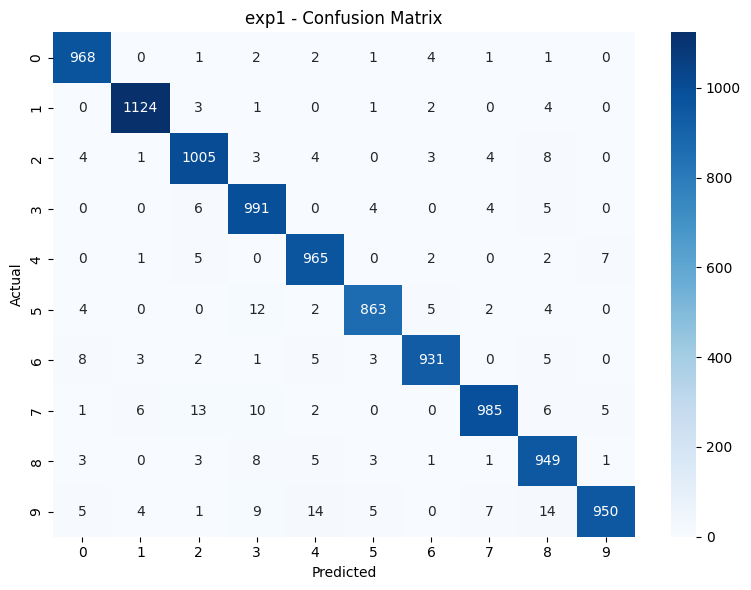

Saved: results/confusion_matrix_exp1.png

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.95      0.97      0.96       974
           9       0.99      0.94      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Saved: results/classification_report_exp1.txt


In [12]:
plot_training_curves(history_exp1, 'exp1')
acc_exp1, pred_exp1, cm_exp1 = evaluate_model(
    model_exp1, X_test, y_test, y_test_raw, 'exp1'
)

---

## 7. Experiment 2: Deeper Network

**Architecture:** `Input(784) → Dense(256, ReLU) → Dense(128, ReLU) → Dense(10, Softmax)`

What changed from Experiment 1:
- **Added a second hidden layer** (256 neurons)
- More layers allow the network to learn more abstract features
- First layer learns simple patterns (edges), second layer combines them into higher-level features
- **Risk:** More parameters = more prone to overfitting

In [13]:
tf.random.set_seed(42)
model_exp2 = build_model_exp2()
model_exp2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_exp2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history_exp2 = model_exp2.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 2:58 424ms/step - accuracy: 0.1328 - loss: 2.3201

 20/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4828 - loss: 1.7579    

 39/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5909 - loss: 1.4270

 59/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6537 - loss: 1.2176

 80/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6952 - loss: 1.0741

 97/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7193 - loss: 0.9894

118/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7420 - loss: 0.9091

136/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7571 - loss: 0.8550

159/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7728 - loss: 0.7993

181/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7851 - loss: 0.7557

204/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7958 - loss: 0.7175

225/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8043 - loss: 0.6874

250/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8131 - loss: 0.6564

271/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8196 - loss: 0.6333

291/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8252 - loss: 0.6136

312/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8305 - loss: 0.5947

335/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8358 - loss: 0.5759

354/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8398 - loss: 0.5617

376/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8441 - loss: 0.5466

399/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8482 - loss: 0.5321

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9181 - loss: 0.2832 - val_accuracy: 0.9673 - val_loss: 0.1137


Epoch 2/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9688 - loss: 0.1370

 22/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9681 - loss: 0.1229  

 44/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9655 - loss: 0.1267

 67/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9649 - loss: 0.1274

 93/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9644 - loss: 0.1273

116/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9641 - loss: 0.1273

143/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9638 - loss: 0.1277

170/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9634 - loss: 0.1280

197/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9632 - loss: 0.1282

229/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9631 - loss: 0.1278

253/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9632 - loss: 0.1273

278/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9633 - loss: 0.1267

302/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9635 - loss: 0.1260

325/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9636 - loss: 0.1252

345/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9637 - loss: 0.1246

366/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9639 - loss: 0.1240

391/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9640 - loss: 0.1233

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9642 - loss: 0.1227

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9667 - loss: 0.1114 - val_accuracy: 0.9738 - val_loss: 0.0904


Epoch 3/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9688 - loss: 0.0984

 17/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9772 - loss: 0.0709 

 34/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9773 - loss: 0.0726

 57/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9774 - loss: 0.0738

 81/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9772 - loss: 0.0750

102/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9771 - loss: 0.0757

123/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9769 - loss: 0.0765

147/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9768 - loss: 0.0771

170/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9768 - loss: 0.0775

195/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9767 - loss: 0.0779

216/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9767 - loss: 0.0780

237/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9767 - loss: 0.0780

258/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9768 - loss: 0.0779

280/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9769 - loss: 0.0777

303/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.0775

327/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9771 - loss: 0.0771

349/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9772 - loss: 0.0769

368/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9772 - loss: 0.0767

391/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9773 - loss: 0.0764

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9773 - loss: 0.0762

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9786 - loss: 0.0719 - val_accuracy: 0.9750 - val_loss: 0.0862


Epoch 4/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9844 - loss: 0.0644

 24/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0453 

 50/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0482

 75/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0499

 97/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9865 - loss: 0.0511

122/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9860 - loss: 0.0520

144/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9857 - loss: 0.0525

165/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0529

184/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.0531

209/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0532

233/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0533

255/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0533

277/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0532

300/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0530

325/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0528

349/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0526

369/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0524

392/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0522

413/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0521

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9854 - loss: 0.0493 - val_accuracy: 0.9740 - val_loss: 0.0889


Epoch 5/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9844 - loss: 0.0662

 23/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0362 

 45/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0375

 70/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0382

 93/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0387

115/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0391

137/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0393

159/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9894 - loss: 0.0394

184/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0394

207/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0393

228/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0392

248/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0391

271/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0389

290/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9894 - loss: 0.0388

311/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0385

334/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0383

358/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0380

382/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0378

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0377

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9901 - loss: 0.0351 - val_accuracy: 0.9732 - val_loss: 0.0954


Epoch 6/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9844 - loss: 0.0541

 24/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0288 

 48/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0287

 72/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0288

 96/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0289

117/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0290

143/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0291

167/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0291

187/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0290

208/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0288

227/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0286

254/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0284

277/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0282

300/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0279

323/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0277

349/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0274

372/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0272

396/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0271

420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0270

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9931 - loss: 0.0249 - val_accuracy: 0.9737 - val_loss: 0.0994


Epoch 7/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 1.0000 - loss: 0.0306

 21/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9955 - loss: 0.0180 

 41/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.0184

 71/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0190

 94/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0197

116/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0201

140/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0203

162/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0204

184/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0205

210/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0205

235/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0204

260/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0203

284/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0202

303/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0201

329/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0200

348/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0199

367/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0198

390/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0197

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0196

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9948 - loss: 0.0187 - val_accuracy: 0.9748 - val_loss: 0.0987


Epoch 8/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 1.0000 - loss: 0.0211

 22/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0187 

 47/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0180

 70/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0180

 93/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0182

117/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0184

142/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0185

160/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0185

181/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0185

206/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0185

232/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0184

256/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0183

281/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0182

303/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0182

323/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0181

347/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0180

371/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0179

392/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0178

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0178

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9947 - loss: 0.0177 - val_accuracy: 0.9738 - val_loss: 0.1030


Epoch 9/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 1.0000 - loss: 0.0089

 22/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0175 

 46/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0177

 67/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0181

 90/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0185

115/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0187

136/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0188

161/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0189

182/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0188

204/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0187

227/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0186

250/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0184

273/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0182

294/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0181

317/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0179

340/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0178

360/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0177

383/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0176

403/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0176

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9945 - loss: 0.0172 - val_accuracy: 0.9723 - val_loss: 0.1287


Epoch 10/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9688 - loss: 0.0394

 22/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0196 

 46/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0175

 70/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0167

 91/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0163

114/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0161

131/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0160

151/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0159

167/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0158

190/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0156

212/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0154

235/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0152

258/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0151

282/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0150

303/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0149

329/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0148

347/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0147

372/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0147

394/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0146

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0146

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9953 - loss: 0.0144 - val_accuracy: 0.9693 - val_loss: 0.1315


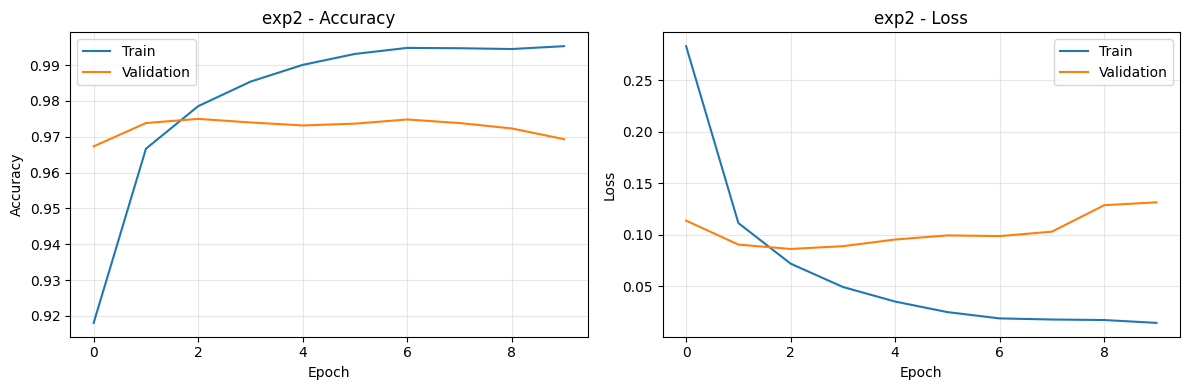

Saved: results/training_curves_exp2.png



exp2 Results:
  Test Loss:     0.1311
  Test Accuracy: 0.9686 (96.86%)


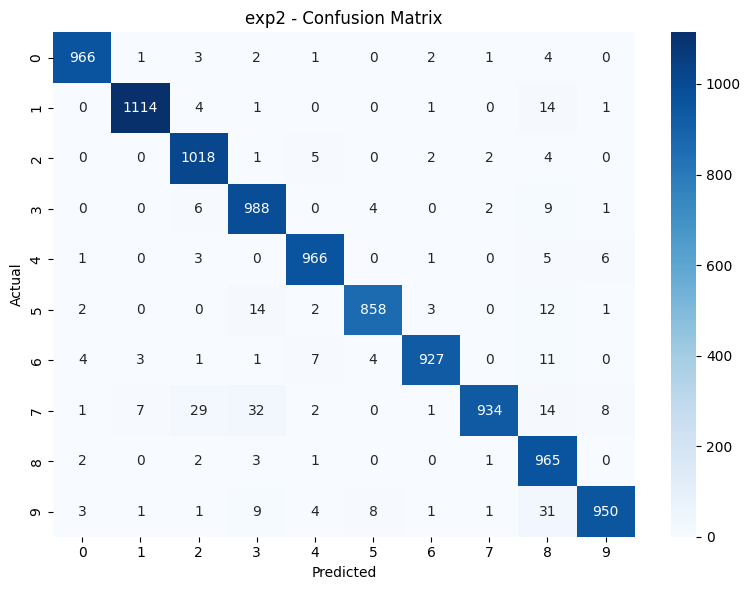

Saved: results/confusion_matrix_exp2.png

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.95      0.99      0.97      1032
           3       0.94      0.98      0.96      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.96      0.97       892
           6       0.99      0.97      0.98       958
           7       0.99      0.91      0.95      1028
           8       0.90      0.99      0.94       974
           9       0.98      0.94      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Saved: results/classification_report_exp2.txt


In [15]:
plot_training_curves(history_exp2, 'exp2')
acc_exp2, pred_exp2, cm_exp2 = evaluate_model(
    model_exp2, X_test, y_test, y_test_raw, 'exp2'
)

---

## 8. Experiment 3: Dropout Regularization

**Architecture:** `Input(784) → Dense(256, ReLU) → Dropout(0.3) → Dense(128, ReLU) → Dropout(0.2) → Dense(10, Softmax)`

What changed from Experiment 2:
- **Added Dropout layers** after each hidden layer
- Dropout randomly "turns off" a fraction of neurons during training
  - `Dropout(0.3)` = 30% of neurons are randomly zeroed each batch
- This forces the network to not rely on any single neuron, improving generalization
- **Key insight:** Training accuracy may be *lower* than Exp 2, but test accuracy should be *higher* (less overfitting)

In [16]:
tf.random.set_seed(42)
model_exp3 = build_model_exp3()
model_exp3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_exp3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history_exp3 = model_exp3.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 3:57 564ms/step - accuracy: 0.0938 - loss: 2.3994

 20/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3710 - loss: 1.9423    

 38/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4790 - loss: 1.6598

 54/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5373 - loss: 1.4883

 73/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5849 - loss: 1.3418

 92/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6197 - loss: 1.2324

111/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6463 - loss: 1.1478

130/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6674 - loss: 1.0801

153/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6881 - loss: 1.0142

173/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7031 - loss: 0.9664

191/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7148 - loss: 0.9293

209/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7251 - loss: 0.8964

227/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7343 - loss: 0.8671

247/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7435 - loss: 0.8379

270/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7529 - loss: 0.8079

290/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7603 - loss: 0.7843

311/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7673 - loss: 0.7617

331/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7735 - loss: 0.7420

353/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7796 - loss: 0.7221

373/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7848 - loss: 0.7054

392/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7894 - loss: 0.6906

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7937 - loss: 0.6769

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8843 - loss: 0.3843 - val_accuracy: 0.9652 - val_loss: 0.1161


Epoch 2/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9375 - loss: 0.1890

 22/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9416 - loss: 0.1861 

 43/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9417 - loss: 0.1904

 64/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9427 - loss: 0.1903

 81/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9429 - loss: 0.1899

100/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9431 - loss: 0.1892

121/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9432 - loss: 0.1887

142/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9434 - loss: 0.1883

164/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9435 - loss: 0.1882

184/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9436 - loss: 0.1879

206/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9437 - loss: 0.1876

228/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9438 - loss: 0.1871

248/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9440 - loss: 0.1866

269/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9442 - loss: 0.1859

288/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9445 - loss: 0.1852

310/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9448 - loss: 0.1843

332/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9450 - loss: 0.1835

363/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9454 - loss: 0.1823

383/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9457 - loss: 0.1815

406/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9459 - loss: 0.1808

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9505 - loss: 0.1662 - val_accuracy: 0.9738 - val_loss: 0.0876


Epoch 3/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9531 - loss: 0.1403

 21/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9640 - loss: 0.1261 

 40/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9641 - loss: 0.1270

 62/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9639 - loss: 0.1269

 82/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9634 - loss: 0.1276

101/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9629 - loss: 0.1279

123/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9626 - loss: 0.1281

144/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9624 - loss: 0.1283

164/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9622 - loss: 0.1285

185/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9621 - loss: 0.1287

206/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9619 - loss: 0.1288

227/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9618 - loss: 0.1288

249/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9618 - loss: 0.1287

267/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9617 - loss: 0.1286

287/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9617 - loss: 0.1285

309/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9617 - loss: 0.1282

330/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9617 - loss: 0.1280

347/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9617 - loss: 0.1277

370/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9618 - loss: 0.1274

389/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9618 - loss: 0.1272

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9618 - loss: 0.1271

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9622 - loss: 0.1234 - val_accuracy: 0.9775 - val_loss: 0.0785


Epoch 4/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9609 - loss: 0.1207

 22/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9679 - loss: 0.0986 

 37/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9687 - loss: 0.0981

 59/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9689 - loss: 0.0990

 79/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9688 - loss: 0.1001

 95/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9687 - loss: 0.1007

118/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9686 - loss: 0.1015

142/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9685 - loss: 0.1021

163/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9685 - loss: 0.1023

185/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9684 - loss: 0.1026

211/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9683 - loss: 0.1028

238/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9683 - loss: 0.1028

259/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9684 - loss: 0.1027

280/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9685 - loss: 0.1025

299/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9685 - loss: 0.1023

318/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9686 - loss: 0.1020

337/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9686 - loss: 0.1018

358/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9687 - loss: 0.1016

380/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9687 - loss: 0.1014

399/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.1013

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.1011

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9696 - loss: 0.0980 - val_accuracy: 0.9782 - val_loss: 0.0726


Epoch 5/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9688 - loss: 0.0946

 21/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9726 - loss: 0.0773 

 44/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9738 - loss: 0.0801

 63/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9741 - loss: 0.0819

 86/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9740 - loss: 0.0833

106/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9740 - loss: 0.0839

128/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9740 - loss: 0.0844

148/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.0847

169/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.0850

189/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.0852

209/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9738 - loss: 0.0854

229/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9738 - loss: 0.0856

249/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9738 - loss: 0.0857

268/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9738 - loss: 0.0857

290/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9738 - loss: 0.0856

315/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.0854

338/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.0853

356/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.0852

379/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.0850

402/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.0849

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9742 - loss: 0.0829 - val_accuracy: 0.9795 - val_loss: 0.0715


Epoch 6/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9766 - loss: 0.1067

 21/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9761 - loss: 0.0795 

 44/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9755 - loss: 0.0808

 66/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9754 - loss: 0.0811

 85/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9753 - loss: 0.0810

106/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9752 - loss: 0.0811

126/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 0.0813

148/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9749 - loss: 0.0814

168/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9749 - loss: 0.0815

189/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9748 - loss: 0.0815

210/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9748 - loss: 0.0815

232/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9748 - loss: 0.0814

252/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9749 - loss: 0.0813

274/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9749 - loss: 0.0811

295/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9749 - loss: 0.0809

317/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 0.0806

337/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9751 - loss: 0.0804

356/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9751 - loss: 0.0801

377/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9752 - loss: 0.0799

394/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9752 - loss: 0.0798

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9753 - loss: 0.0796

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9762 - loss: 0.0760 - val_accuracy: 0.9795 - val_loss: 0.0665


Epoch 7/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9766 - loss: 0.0600

 24/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9818 - loss: 0.0595 

 44/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9816 - loss: 0.0607

 68/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9811 - loss: 0.0615

 89/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9806 - loss: 0.0625

110/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9801 - loss: 0.0632

130/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9798 - loss: 0.0639

152/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9794 - loss: 0.0646

176/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9792 - loss: 0.0651

195/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0654

213/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0654

233/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0655

256/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0656

276/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0655

298/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0655

320/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0654

339/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9792 - loss: 0.0652

360/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9792 - loss: 0.0651

377/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9792 - loss: 0.0650

400/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9792 - loss: 0.0649

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9795 - loss: 0.0635 - val_accuracy: 0.9822 - val_loss: 0.0617


Epoch 8/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9922 - loss: 0.0525

 26/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - loss: 0.0528 

 49/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9831 - loss: 0.0545

 71/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9825 - loss: 0.0556

 88/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0563

110/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0569

134/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.0572

154/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0573

174/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0573

198/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0574

219/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0574

239/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0573

260/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.0572

278/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.0571

300/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.0570

321/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9816 - loss: 0.0570

341/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9816 - loss: 0.0569

365/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9816 - loss: 0.0568

387/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0567

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0567

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9821 - loss: 0.0558 - val_accuracy: 0.9815 - val_loss: 0.0649


Epoch 9/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9766 - loss: 0.0581

 25/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.0427 

 49/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.0456

 71/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - loss: 0.0486

 94/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0505

117/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0516

139/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9832 - loss: 0.0523

162/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9831 - loss: 0.0529

183/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9829 - loss: 0.0533

207/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9829 - loss: 0.0535

225/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9828 - loss: 0.0536

247/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9828 - loss: 0.0536

270/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9828 - loss: 0.0536

292/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9829 - loss: 0.0534

315/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9829 - loss: 0.0533

337/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9829 - loss: 0.0531

358/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9830 - loss: 0.0530

386/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9830 - loss: 0.0529

408/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9830 - loss: 0.0529

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9833 - loss: 0.0520 - val_accuracy: 0.9840 - val_loss: 0.0610


Epoch 10/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9922 - loss: 0.0302

 22/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0370 

 45/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.0394

 66/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9849 - loss: 0.0416

 86/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9847 - loss: 0.0431

105/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.0440

122/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9844 - loss: 0.0446

143/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9843 - loss: 0.0451

164/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9843 - loss: 0.0454

186/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9843 - loss: 0.0456

204/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9843 - loss: 0.0456

223/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9843 - loss: 0.0457

245/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9843 - loss: 0.0458

264/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9844 - loss: 0.0458

285/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9844 - loss: 0.0458

303/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9845 - loss: 0.0458

326/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9845 - loss: 0.0457

351/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.0457

372/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9846 - loss: 0.0456

395/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9846 - loss: 0.0456

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9846 - loss: 0.0455

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9851 - loss: 0.0451 - val_accuracy: 0.9827 - val_loss: 0.0685


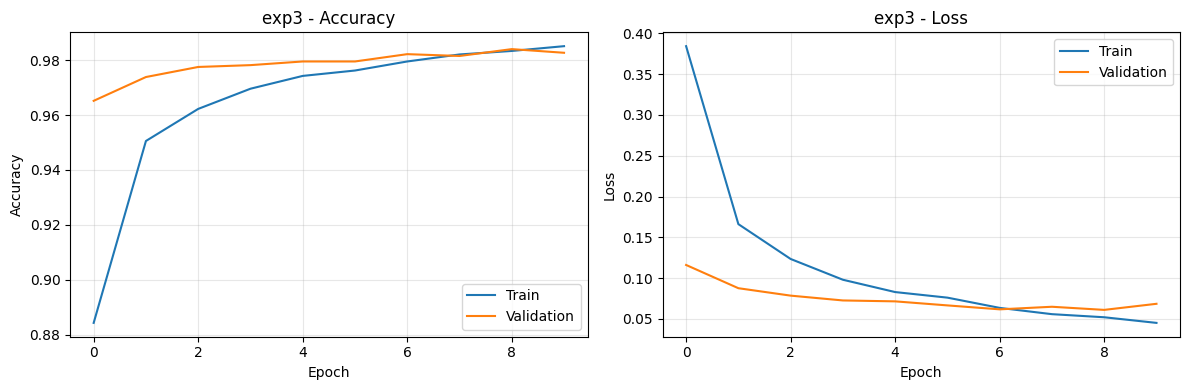

Saved: results/training_curves_exp3.png



exp3 Results:
  Test Loss:     0.0672
  Test Accuracy: 0.9811 (98.11%)


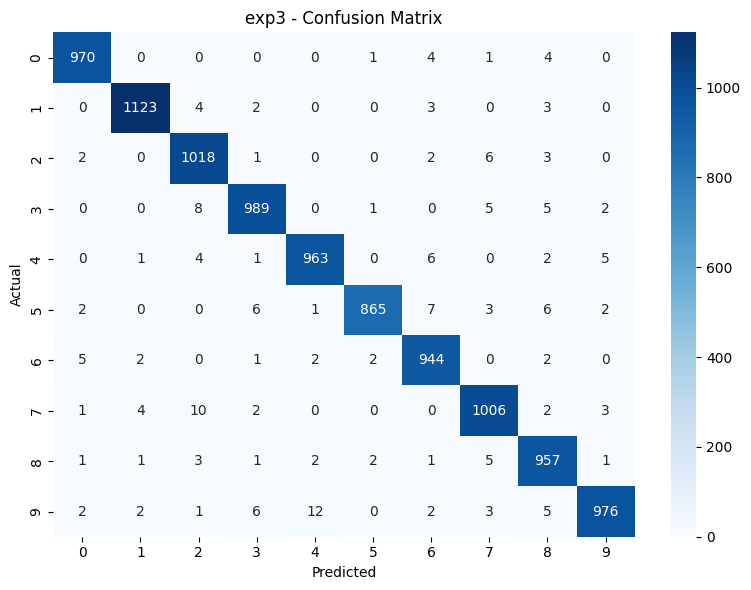

Saved: results/confusion_matrix_exp3.png

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.97      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Saved: results/classification_report_exp3.txt


In [18]:
plot_training_curves(history_exp3, 'exp3')
acc_exp3, pred_exp3, cm_exp3 = evaluate_model(
    model_exp3, X_test, y_test, y_test_raw, 'exp3'
)

---

## 9. Experiment 4: Tuned Network

**Architecture:** `Input(784) → Dense(512, ReLU) → Dropout(0.3) → Dense(256, ReLU) → Dropout(0.2) → Dense(128, ReLU) → Dense(10, Softmax)`

What changed from Experiment 3:
- **Wider first layer** (512 vs 256 neurons) — can learn more features
- **Three hidden layers** instead of two — deeper feature hierarchy
- Dropout still applied to prevent overfitting from the increased capacity
- **Trade-off:** More parameters and longer training time, but potentially better accuracy

In [19]:
tf.random.set_seed(42)
model_exp4 = build_model_exp4()
model_exp4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_exp4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history_exp4 = model_exp4.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 3:34 510ms/step - accuracy: 0.0781 - loss: 2.3888

 16/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3731 - loss: 1.9507    

 31/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4911 - loss: 1.6235

 45/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5544 - loss: 1.4314

 59/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5986 - loss: 1.2939

 72/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6292 - loss: 1.1978

 87/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6570 - loss: 1.1099

101/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6779 - loss: 1.0436

117/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6973 - loss: 0.9816

133/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7134 - loss: 0.9302

148/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7262 - loss: 0.8891

163/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7374 - loss: 0.8533

177/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7466 - loss: 0.8238

192/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7554 - loss: 0.7955

207/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7633 - loss: 0.7700

223/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7709 - loss: 0.7455

237/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7770 - loss: 0.7260

251/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7826 - loss: 0.7080

267/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7885 - loss: 0.6890

282/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7937 - loss: 0.6725

296/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7981 - loss: 0.6582

311/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8026 - loss: 0.6438

326/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8068 - loss: 0.6303

341/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8107 - loss: 0.6177

355/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8141 - loss: 0.6066

370/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8176 - loss: 0.5954

385/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8209 - loss: 0.5849

399/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8238 - loss: 0.5755

414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8267 - loss: 0.5661

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9064 - loss: 0.3086 - val_accuracy: 0.9713 - val_loss: 0.0946


Epoch 2/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9609 - loss: 0.1700

 17/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9581 - loss: 0.1373 

 30/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9577 - loss: 0.1369

 45/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9577 - loss: 0.1379

 61/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9575 - loss: 0.1390

 76/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9571 - loss: 0.1401

 90/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9567 - loss: 0.1407

105/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9565 - loss: 0.1411

119/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9564 - loss: 0.1416

133/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9562 - loss: 0.1421

148/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9560 - loss: 0.1427

162/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9559 - loss: 0.1431

176/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9558 - loss: 0.1434

193/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9557 - loss: 0.1438

207/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9557 - loss: 0.1439

224/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9556 - loss: 0.1440

239/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9557 - loss: 0.1440

254/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9557 - loss: 0.1440

268/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9557 - loss: 0.1438

283/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9558 - loss: 0.1436

298/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9559 - loss: 0.1434

313/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9560 - loss: 0.1431

328/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9561 - loss: 0.1428

341/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9562 - loss: 0.1425

355/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9563 - loss: 0.1422

371/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9564 - loss: 0.1419

387/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9565 - loss: 0.1416

402/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9566 - loss: 0.1413

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9566 - loss: 0.1411

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9592 - loss: 0.1327 - val_accuracy: 0.9762 - val_loss: 0.0777


Epoch 3/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9766 - loss: 0.1013

 16/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9676 - loss: 0.0896 

 31/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9683 - loss: 0.0916

 44/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9688 - loss: 0.0919

 59/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9693 - loss: 0.0927

 73/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9692 - loss: 0.0938

 89/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9692 - loss: 0.0947

103/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9691 - loss: 0.0952

117/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9691 - loss: 0.0956

132/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9692 - loss: 0.0960

148/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9692 - loss: 0.0965

164/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9692 - loss: 0.0968

178/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9692 - loss: 0.0971

193/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9692 - loss: 0.0975

206/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9692 - loss: 0.0977

224/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9693 - loss: 0.0979

239/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9693 - loss: 0.0980

254/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9693 - loss: 0.0980

269/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9694 - loss: 0.0980

283/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9694 - loss: 0.0980

296/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9694 - loss: 0.0979

311/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9695 - loss: 0.0978

326/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9695 - loss: 0.0977

341/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9695 - loss: 0.0976

355/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9696 - loss: 0.0975

369/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9696 - loss: 0.0975

385/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9696 - loss: 0.0974

398/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9696 - loss: 0.0973

413/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9696 - loss: 0.0973

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9702 - loss: 0.0947 - val_accuracy: 0.9783 - val_loss: 0.0720


Epoch 4/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9688 - loss: 0.1077

 15/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9755 - loss: 0.0675 

 31/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9771 - loss: 0.0693

 44/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9773 - loss: 0.0699

 60/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9771 - loss: 0.0712

 75/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9769 - loss: 0.0724

 89/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9767 - loss: 0.0733

103/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9765 - loss: 0.0742

118/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9763 - loss: 0.0751

133/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9760 - loss: 0.0761

147/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9757 - loss: 0.0769

163/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9755 - loss: 0.0776

177/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9753 - loss: 0.0782

193/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9752 - loss: 0.0787

207/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9751 - loss: 0.0790

220/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9751 - loss: 0.0791

235/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9751 - loss: 0.0793

251/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9751 - loss: 0.0794

266/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9751 - loss: 0.0794

281/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9752 - loss: 0.0794

296/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9752 - loss: 0.0793

311/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9752 - loss: 0.0793

326/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9753 - loss: 0.0791

343/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9753 - loss: 0.0790

357/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9754 - loss: 0.0789

371/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9754 - loss: 0.0788

386/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9755 - loss: 0.0787

398/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9755 - loss: 0.0786

412/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9755 - loss: 0.0785

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9765 - loss: 0.0766 - val_accuracy: 0.9765 - val_loss: 0.0778


Epoch 5/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9922 - loss: 0.0584

 15/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9874 - loss: 0.0511 

 30/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9842 - loss: 0.0592

 45/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9829 - loss: 0.0628

 59/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9824 - loss: 0.0642

 74/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9821 - loss: 0.0651

 90/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9819 - loss: 0.0656

104/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9817 - loss: 0.0659

119/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9814 - loss: 0.0661

134/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9812 - loss: 0.0663

148/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9810 - loss: 0.0666

164/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9808 - loss: 0.0668

177/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9807 - loss: 0.0669

191/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9806 - loss: 0.0671

206/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9805 - loss: 0.0672

221/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9804 - loss: 0.0673

236/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9803 - loss: 0.0674

249/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9802 - loss: 0.0675

264/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9801 - loss: 0.0675

280/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9801 - loss: 0.0675

296/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9800 - loss: 0.0674

311/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9800 - loss: 0.0673

326/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9800 - loss: 0.0673

337/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9799 - loss: 0.0672

351/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9799 - loss: 0.0672

366/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9799 - loss: 0.0671

382/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9798 - loss: 0.0671

397/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9798 - loss: 0.0670

411/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9798 - loss: 0.0670

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9791 - loss: 0.0659 - val_accuracy: 0.9793 - val_loss: 0.0666


Epoch 6/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9766 - loss: 0.1048

 15/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9851 - loss: 0.0557 

 29/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9848 - loss: 0.0552

 44/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9844 - loss: 0.0551

 58/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9842 - loss: 0.0551

 72/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9838 - loss: 0.0557

 87/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9834 - loss: 0.0561

101/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9831 - loss: 0.0564

115/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9828 - loss: 0.0568

131/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9825 - loss: 0.0572

146/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9822 - loss: 0.0577

157/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9820 - loss: 0.0580

168/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9819 - loss: 0.0582

184/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9818 - loss: 0.0584

198/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9817 - loss: 0.0586

212/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9816 - loss: 0.0587

228/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9815 - loss: 0.0587

245/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9815 - loss: 0.0588

256/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9815 - loss: 0.0588

272/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9815 - loss: 0.0587

288/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9815 - loss: 0.0586

302/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9815 - loss: 0.0585

317/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9816 - loss: 0.0583

331/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9816 - loss: 0.0581

346/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9816 - loss: 0.0580

361/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9817 - loss: 0.0579

376/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9817 - loss: 0.0578

392/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9817 - loss: 0.0577

405/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9817 - loss: 0.0576

421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9817 - loss: 0.0575

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9823 - loss: 0.0549 - val_accuracy: 0.9810 - val_loss: 0.0665


Epoch 7/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9688 - loss: 0.0733

 16/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9835 - loss: 0.0442 

 32/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9845 - loss: 0.0431

 49/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9850 - loss: 0.0434

 64/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9850 - loss: 0.0445

 79/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9849 - loss: 0.0457

 95/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9847 - loss: 0.0468

109/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9844 - loss: 0.0476

124/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9842 - loss: 0.0485

139/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9839 - loss: 0.0493

154/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9837 - loss: 0.0500

169/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9835 - loss: 0.0506

184/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9833 - loss: 0.0511

200/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9832 - loss: 0.0515

216/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9831 - loss: 0.0518

232/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0520

248/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0521

262/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9829 - loss: 0.0522

277/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9829 - loss: 0.0522

293/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0522

308/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0521

324/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0521

337/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0520

352/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9831 - loss: 0.0520

368/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9831 - loss: 0.0519

385/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9831 - loss: 0.0519

402/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9831 - loss: 0.0520

416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9831 - loss: 0.0520

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9834 - loss: 0.0518 - val_accuracy: 0.9838 - val_loss: 0.0571


Epoch 8/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9766 - loss: 0.0514

 16/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9918 - loss: 0.0233 

 30/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9904 - loss: 0.0270

 46/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9893 - loss: 0.0298

 61/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9884 - loss: 0.0324

 77/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9877 - loss: 0.0345

 91/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9872 - loss: 0.0357

106/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9869 - loss: 0.0367

122/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9867 - loss: 0.0374

135/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9865 - loss: 0.0379

151/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9864 - loss: 0.0384

166/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9863 - loss: 0.0388

181/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9862 - loss: 0.0390

195/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9862 - loss: 0.0393

211/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9861 - loss: 0.0395

227/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9860 - loss: 0.0397

243/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9860 - loss: 0.0399

258/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9860 - loss: 0.0401

272/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9859 - loss: 0.0402

288/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9859 - loss: 0.0403

303/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9859 - loss: 0.0405

319/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9858 - loss: 0.0406

333/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9858 - loss: 0.0408

347/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9858 - loss: 0.0409

362/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9857 - loss: 0.0411

375/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9857 - loss: 0.0412

390/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9856 - loss: 0.0414

404/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9856 - loss: 0.0415

419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9855 - loss: 0.0417

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9843 - loss: 0.0459 - val_accuracy: 0.9828 - val_loss: 0.0661


Epoch 9/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9922 - loss: 0.0161

 16/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9918 - loss: 0.0286 

 32/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9897 - loss: 0.0355

 46/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9891 - loss: 0.0373

 62/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9887 - loss: 0.0386

 77/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9884 - loss: 0.0395

 91/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9882 - loss: 0.0401

106/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9880 - loss: 0.0406

122/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9878 - loss: 0.0410

137/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9876 - loss: 0.0413

152/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9875 - loss: 0.0415

167/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0417

182/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0418

196/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0418

208/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9872 - loss: 0.0419

222/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9872 - loss: 0.0420

236/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9871 - loss: 0.0421

248/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9870 - loss: 0.0422

262/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9870 - loss: 0.0423

278/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9869 - loss: 0.0424

292/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9869 - loss: 0.0425

305/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9868 - loss: 0.0425

322/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9868 - loss: 0.0425

340/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9867 - loss: 0.0425

357/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9867 - loss: 0.0425

372/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9867 - loss: 0.0425

386/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9867 - loss: 0.0425

400/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9867 - loss: 0.0425

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9867 - loss: 0.0425

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9863 - loss: 0.0418 - val_accuracy: 0.9835 - val_loss: 0.0670


Epoch 10/10


  1/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9922 - loss: 0.0140

 15/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9914 - loss: 0.0230 

 30/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9913 - loss: 0.0254

 44/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9904 - loss: 0.0291

 60/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9896 - loss: 0.0323

 75/422 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9890 - loss: 0.0346

 90/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9885 - loss: 0.0361

106/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9882 - loss: 0.0372

120/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9879 - loss: 0.0380

135/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9877 - loss: 0.0387

150/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9875 - loss: 0.0392

165/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0396

180/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0398

194/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0399

210/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0399

225/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0399

239/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0399

253/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0399

268/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0399

282/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0398

297/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0398

312/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0397

326/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9875 - loss: 0.0397

342/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9875 - loss: 0.0397

357/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9875 - loss: 0.0397

371/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9875 - loss: 0.0398

385/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0398

399/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0398

415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0399

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9868 - loss: 0.0412 - val_accuracy: 0.9795 - val_loss: 0.0681


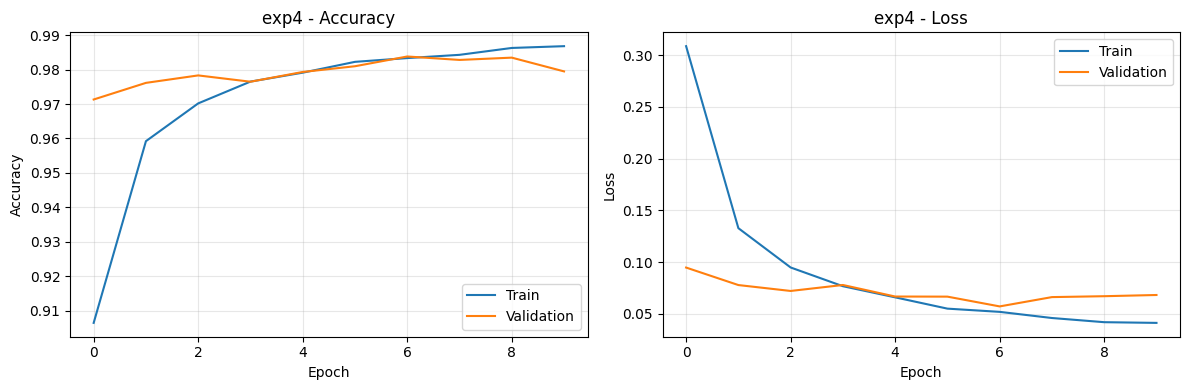

Saved: results/training_curves_exp4.png



exp4 Results:
  Test Loss:     0.0664
  Test Accuracy: 0.9812 (98.12%)


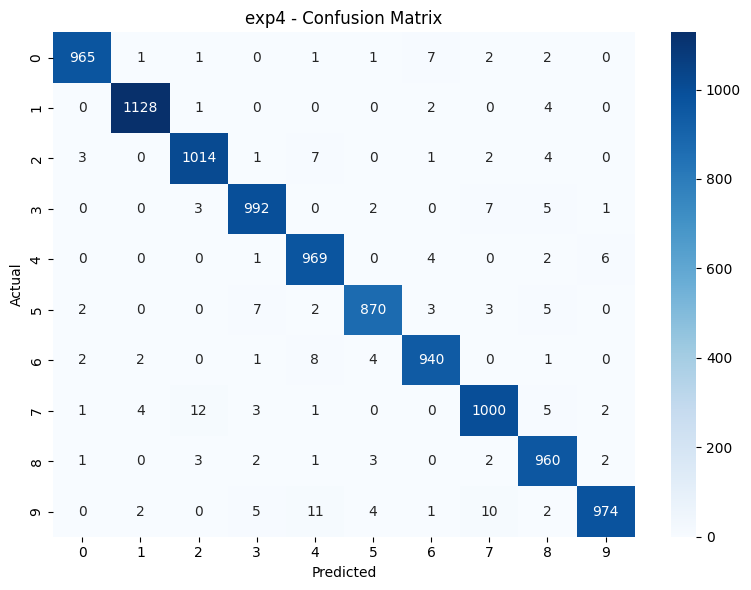

Saved: results/confusion_matrix_exp4.png

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.99      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Saved: results/classification_report_exp4.txt


In [21]:
plot_training_curves(history_exp4, 'exp4')
acc_exp4, pred_exp4, cm_exp4 = evaluate_model(
    model_exp4, X_test, y_test, y_test_raw, 'exp4'
)

---

## 10. Results Comparison

Let's compare all 4 experiments side by side to see how each architectural change affected performance.

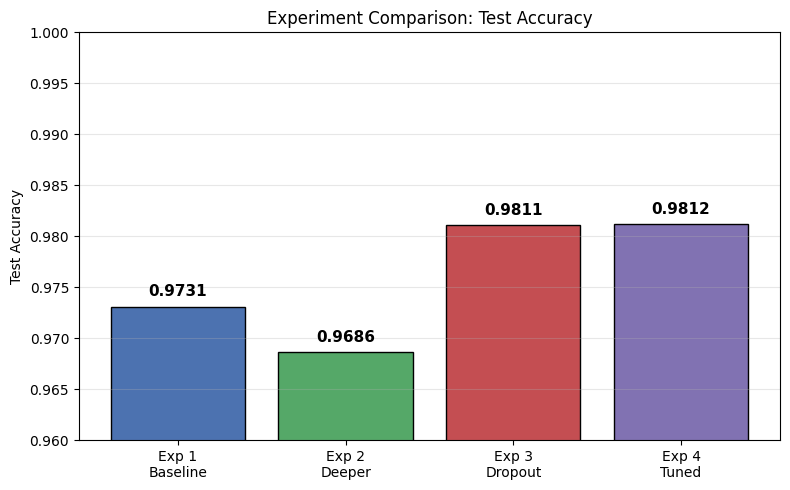

In [22]:
# Comparison bar chart
exp_names = ['Exp 1\nBaseline', 'Exp 2\nDeeper', 'Exp 3\nDropout', 'Exp 4\nTuned']
accuracies = [acc_exp1, acc_exp2, acc_exp3, acc_exp4]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(exp_names, accuracies, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'],
              edgecolor='black')
ax.set_ylabel('Test Accuracy')
ax.set_title('Experiment Comparison: Test Accuracy')
ax.set_ylim(0.96, 1.0)  # Zoom in to see differences
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
            f'{acc:.4f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('results/experiment_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Sample Predictions
Let's visualize some correct and incorrect predictions from our best model.

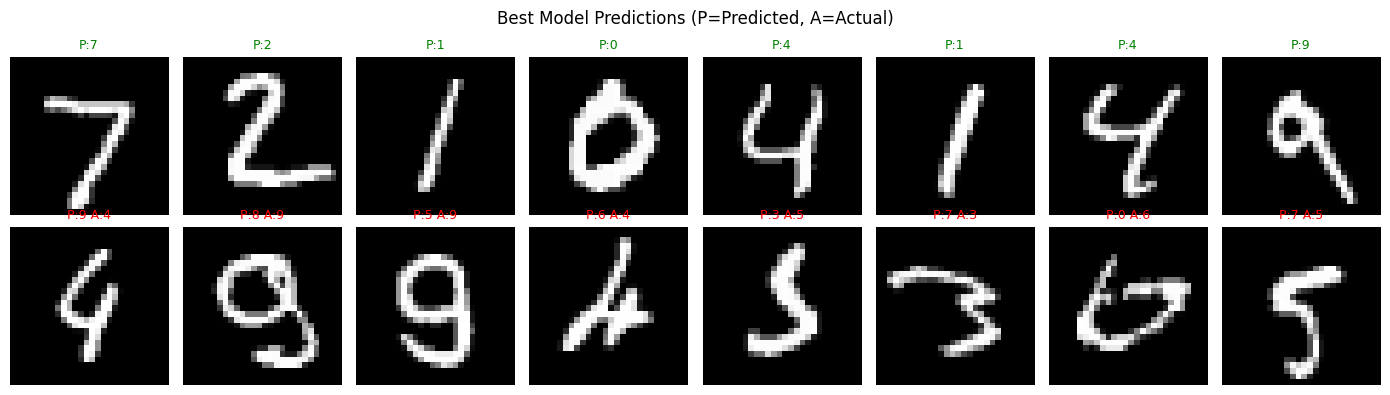

In [23]:
# Use the best model (exp4) predictions
best_pred = pred_exp4
correct_mask = (best_pred == y_test_raw)
incorrect_mask = ~correct_mask

correct_idx = np.where(correct_mask)[0][:8]
incorrect_idx = np.where(incorrect_mask)[0][:8]

fig, axes = plt.subplots(2, 8, figsize=(14, 4))

# Top row: correct predictions
for i, idx in enumerate(correct_idx):
    axes[0, i].imshow(X_test_raw[idx], cmap='gray')
    axes[0, i].set_title(f'P:{best_pred[idx]}', fontsize=9, color='green')
    axes[0, i].axis('off')
axes[0, 0].set_ylabel('Correct', fontsize=10, color='green')

# Bottom row: incorrect predictions
for i, idx in enumerate(incorrect_idx):
    axes[1, i].imshow(X_test_raw[idx], cmap='gray')
    axes[1, i].set_title(f'P:{best_pred[idx]} A:{y_test_raw[idx]}',
                         fontsize=9, color='red')
    axes[1, i].axis('off')
axes[1, 0].set_ylabel('Wrong', fontsize=10, color='red')

plt.suptitle('Best Model Predictions (P=Predicted, A=Actual)', fontsize=12)
plt.tight_layout()
plt.savefig('results/sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Conclusions

### Key Takeaways

1. **Baseline works well:** Even a simple single-layer network achieves ~97% on MNIST — the dataset is relatively easy for neural networks.

2. **Depth helps:** Adding a second hidden layer (Exp 2) allows the network to learn more complex features, giving a modest improvement.

3. **Dropout prevents overfitting:** Experiment 3 shows that dropout regularization helps the model generalize better to unseen data, even if training accuracy is slightly lower.

4. **Wider + deeper + dropout:** Experiment 4 combines all benefits — more capacity to learn (wider/deeper) with regularization to prevent overfitting (dropout).

### Common Confusion Pairs
Looking at the confusion matrices, the most commonly confused digit pairs tend to be:
- **4 and 9** — visually similar strokes
- **3 and 8** — similar curves
- **7 and 1** — both have vertical strokes

### What Next?
To push beyond ~98.5%, we would need:
- **Convolutional Neural Networks (CNNs)** — preserve spatial information
- **Data augmentation** — small rotations, shifts to increase training variety
- **Learning rate scheduling** — reduce learning rate as training progresses